Epoch 1/173


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9359
Epoch 2/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8710
Epoch 3/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8550
Epoch 4/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6900
Epoch 5/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7513
Epoch 6/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7073
Epoch 7/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6752
Epoch 8/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6503
Epoch 9/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5824
Epoch 10/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7101
Epoch 11/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6323
Epoch 12/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6268
Epoch 13/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5475
Epoch 14/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5595
Epoch 15/173
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5949
E

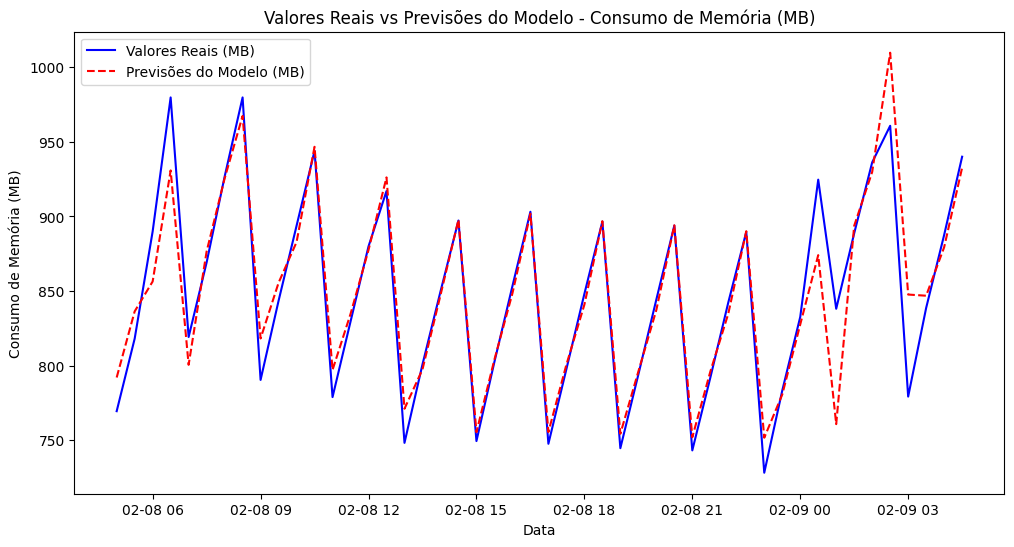

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Carregar os dados
metric_df = pd.read_pickle("../data/ts.pkl")

# Resample para intervalos de 30 minutos
ts = metric_df["value"].astype(float).resample("30min").mean()

# Dividir em treino e teste
train = ts[:"2021-02-07"]
test = ts["2021-02-08":]

# Escalonar os dados
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Hiperparâmetros obtidos do melhor resultado
lstm_units = 105
dropout_rate = 0.0
batch_size = 16
learning_rate = 0.000801
n_steps = 10
epochs = 173

# Criar sequências de input data para treino
X_train, y_train = [], []
for i in range(n_steps, len(train_scaled)):
    X_train.append(train_scaled[i-n_steps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Criar sequências de input data para teste
X_test, y_test = [], []
for j in range(n_steps, len(test_scaled)):
    X_test.append(test_scaled[j-n_steps:j, 0])
    y_test.append(test_scaled[j, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape para 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Definir o modelo com os melhores hiperparâmetros
model = Sequential()
model.add(LSTM(lstm_units, activation='tanh', input_shape=(n_steps, 1), return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units, activation='tanh'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

# Compilar o modelo com o otimizador Adam e a taxa de aprendizado especificada
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Treinar o modelo
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Fazer previsões no conjunto de teste
test_pred = model.predict(X_test)
test_pred = scaler.inverse_transform(test_pred)  # Reverter o escalonamento para o formato original

# Converter para MB
test_pred_mb = test_pred / 10**6  # Convertendo bytes para MB
test_values_mb = test.values[n_steps:] / 10**6  # Convertendo os valores reais para MB

# Visualização dos resultados
plt.figure(figsize=(12, 6))

# Plotar os valores reais de consumo de memória (em MB)
plt.plot(test.index[n_steps:], test_values_mb, label="Valores Reais (MB)", color='blue')

# Plotar as previsões do modelo (em MB)
plt.plot(test.index[n_steps:], test_pred_mb, label="Previsões do Modelo (MB)", color='red', linestyle='--')

# Adicionar título e legendas
plt.title("Valores Reais vs Previsões do Modelo - Consumo de Memória (MB)")
plt.xlabel("Data")
plt.ylabel("Consumo de Memória (MB)")
plt.legend()

# Exibir o gráfico
plt.show()
